# Long Short Term Memory(LSTM) based - Stock predicition - # CPU based

Aim -to predict the Opening stock price using past 60 day stock price.



In [112]:
import math
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf

## Data prep

Works on Yahoo based data. (Doesnt contain Indian stock values) 

In [113]:
ticker = 'AAPL'

In [ ]:
ticker = '^IXIC'

In [ ]:
ticker = 'AMZN'  #amazon  start=   end = current date

In [ ]:
ticker = 'TSLA'  #Tesla start=   end = current date

In [ ]:
ticker = 'UBER'  #Uber start=   end = current date

In [ ]:
ticker = 'TSLA'  #Tesla start=   end = current date

Change start and end date for collection, as per Company.  (Start date cant be before the company was founded.)

Different approaches can be used for Date collection - 


1.   Pretrain on 20+ year dataset, finetune for local
2.   Event specific timings - As in 2020, covid may lead to a new stock trading pattern.



In [114]:
#Get stock quote - we import just the opening and closing Prices of stock, over 20 years duration

#df=web.DataReader('AAPL', 'yahoo', start='2015-01-01', end='2020-05-24')    #YYYY-MM-DD
yf.pdr_override()
df=pdr.get_data_yahoo(ticker, start='2015-01-01', end='2022-12-30')
print(df)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   27.847500   27.860001   26.837500   27.332500   24.531767   
2015-01-05   27.072500   27.162500   26.352501   26.562500   23.840666   
2015-01-06   26.635000   26.857500   26.157499   26.565001   23.842911   
2015-01-07   26.799999   27.049999   26.674999   26.937500   24.177246   
2015-01-08   27.307501   28.037500   27.174999   27.972500   25.106188   
...                ...         ...         ...         ...         ...   
2022-12-22  134.350006  134.559998  130.300003  132.229996  131.846039   
2022-12-23  130.919998  132.419998  129.639999  131.860001  131.477127   
2022-12-27  131.380005  131.410004  128.720001  130.029999  129.652435   
2022-12-28  129.669998  131.029999  125.870003  126.040001  125.674026   
2022-12-29  127.989998  130.479996  127.730

In [115]:
df.shape

(2013, 6)

In [116]:
#choose plotting style

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
plt.style.use('seaborn')

<ipython-input-116-9bfc1a6cb048>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


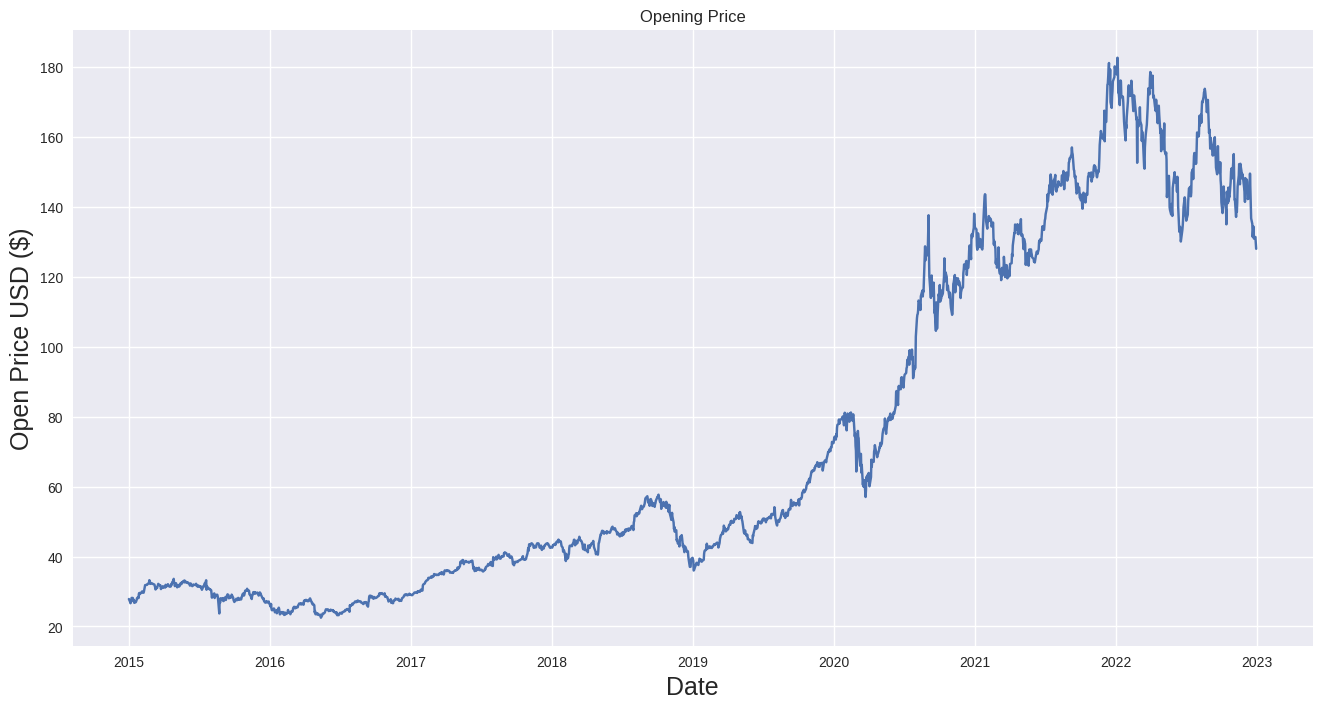

In [117]:
plt.figure(figsize=(16,8))
plt.title('Opening Price')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

In [118]:
data=df.filter(['Open'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on
#math.ceil to round up 

training_data_len = math.ceil(len(dataset)*.8)


#print(dataset)
training_data_len

1611

In [119]:
#Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)



In [120]:
#Create training dataset
#Create scaled training dataset

train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set

x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.03339474, 0.02855492, 0.02582277, 0.02685318, 0.03002249,
       0.03539311, 0.03528383, 0.03345719, 0.02972585, 0.03122463,
       0.02658777, 0.02785236, 0.02958533, 0.03163055, 0.03481547,
       0.03706363, 0.03500281, 0.04313682, 0.04109161, 0.04433898,
       0.04379255, 0.0444951 , 0.0444951 , 0.04686816, 0.04686816,
       0.04457316, 0.04710235, 0.05116155, 0.056298  , 0.05820271,
       0.05853056, 0.05874914, 0.06007618, 0.06029475, 0.06248049,
       0.06703928, 0.06488478, 0.06056016, 0.06244926, 0.06127833,
       0.06082559, 0.06104416, 0.06023231, 0.05995128, 0.05926434,
       0.05684444, 0.05425279, 0.05044338, 0.05370636, 0.05289452,
       0.05604821, 0.05776556, 0.06049772, 0.0597171 , 0.05795292,
       0.05812465, 0.0570474 , 0.05114595, 0.05397177, 0.05315994])]
[0.05634483737807644]



In [121]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [122]:
#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1551, 60, 1)

## Model training 

In [123]:
#Build LSTM model
model=Sequential()
#Add first layer to model
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Add second layer to model
model.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model.add(Dense(1))

In [124]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=["acc"])


In [125]:
#Train the model
history = model.fit(x_train, y_train, batch_size=100,epochs=100)

Epoch 1/100
16/16 [==============================] - 4s 56ms/step - loss: 0.0251 - acc: 6.4475e-04
Epoch 2/100
16/16 [==============================] - 1s 57ms/step - loss: 0.0022 - acc: 6.4475e-04
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 6.7180e-04 - acc: 6.4475e-04
Epoch 4/100
16/16 [==============================] - 1s 55ms/step - loss: 4.0991e-04 - acc: 6.4475e-04
Epoch 5/100
16/16 [==============================] - 1s 79ms/step - loss: 3.6195e-04 - acc: 6.4475e-04
Epoch 6/100
16/16 [==============================] - 1s 71ms/step - loss: 3.5236e-04 - acc: 6.4475e-04
Epoch 7/100
16/16 [==============================] - 1s 55ms/step - loss: 3.5162e-04 - acc: 6.4475e-04
Epoch 8/100
16/16 [==============================] - 1s 57ms/step - loss: 3.2492e-04 - acc: 6.4475e-04
Epoch 9/100
16/16 [==============================] - 1s 56ms/step - loss: 3.0935e-04 - acc: 6.4475e-04
Epoch 10/100
16/16 [==============================] - 1s 56ms/step - loss: 3.1496

## Testing and Validating model

In [126]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    


In [127]:
#Convert the data to a numpy array

x_test=np.array(x_test)


In [128]:
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))


In [129]:
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)


13/13 [==============================] - 1s 11ms/step


In [130]:
#Get root mean squared error(RMSE)

rmse =np.sqrt(np.mean(predictions-y_test)**2)
rmse



3.0629880535068796

In [131]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

#Get root mean squared error(RMSE)
rmse =np.sqrt(np.mean(predictions-y_test)**2)

print(rmse, mean_absolute_error(y_test,predictions))

3.0629880535068796 3.9538956827192164


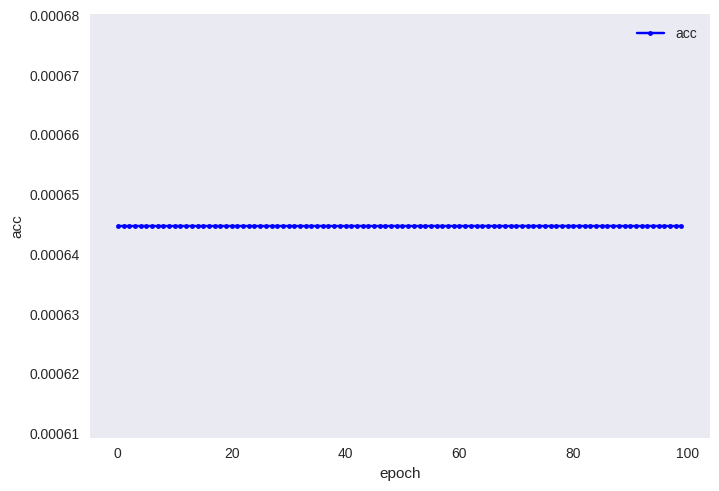

In [133]:
y_acc = history.history['acc']
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_acc, marker='.', c='blue', label="acc")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

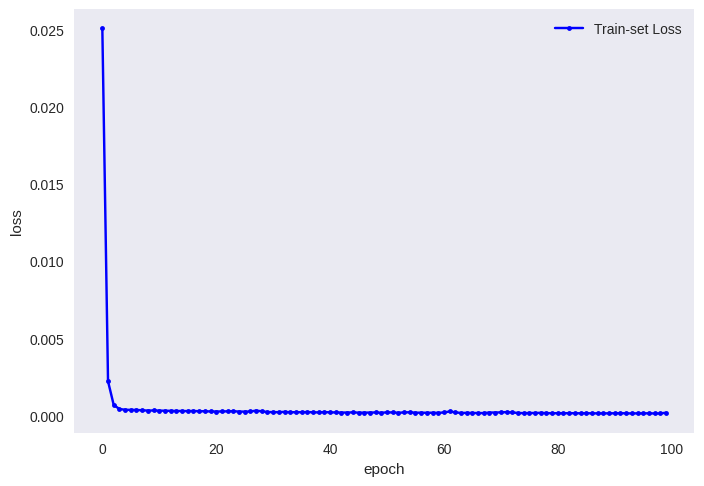

In [134]:
y_loss = history.history['loss']
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [135]:
def MAE(Original, Expectation):
  n = float(0)
  #print(len(Expectation))
  for i in range(0, len(Original)):
    n += abs(Original[i]- Expectation[i])
  return n/len(Original)
print(MAE(y_test, predictions))

[3.95389568]


In [136]:
from sklearn.metrics import mean_absolute_error


In [137]:
def MAPE(Original, Expectation):
  n = float(0)
  for i in range(0, len(Original)):
    n += abs((Original[i]- Expectation[i])/ (Original[i])) * 100
  n /= len(Original)
  return n
print(MAPE(y_test, predictions))

[2.53580019]


In [138]:
#choose plotting style

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
#plt.style.use('ggplot')
#plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
plt.style.use('seaborn')

<ipython-input-138-9bfc1a6cb048>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<ipython-input-139-0e1b27b852eb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


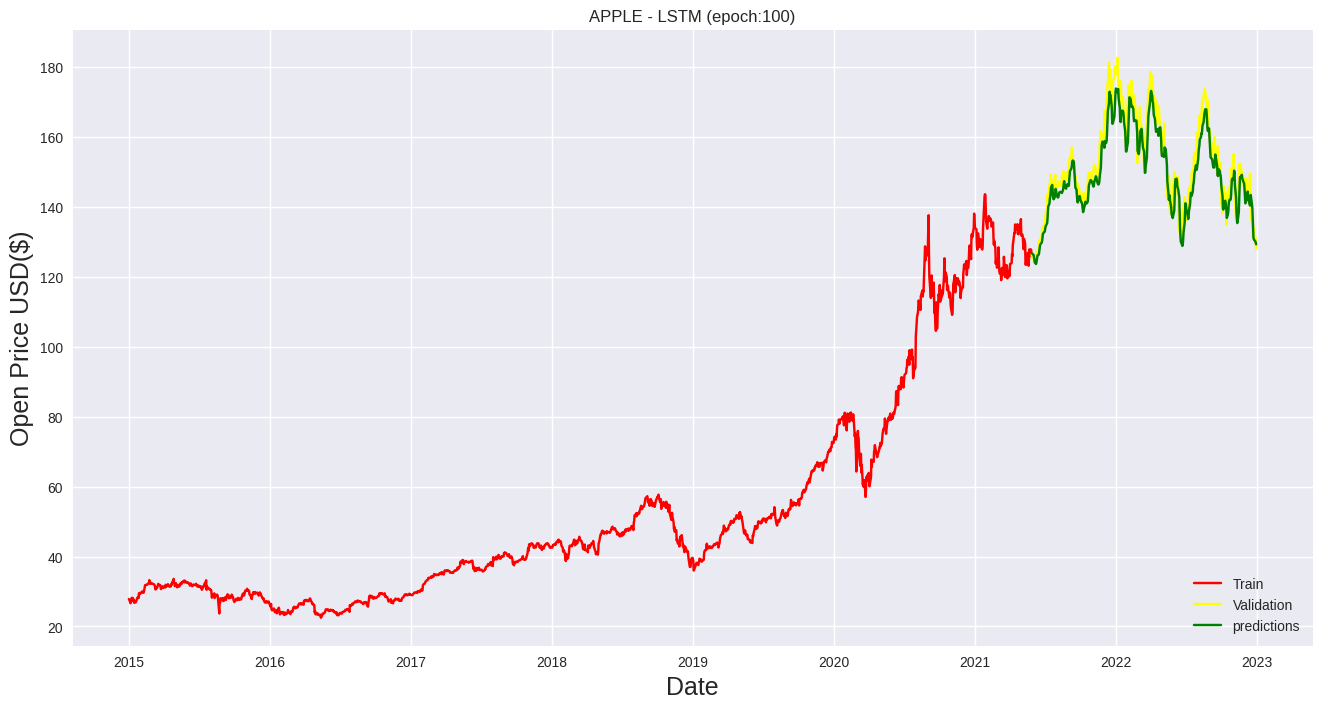

In [139]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('APPLE - LSTM (epoch:100)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train['Open'] , color='red')
plt.plot(valid['Open'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
#plt.savefig('/content/prediction.png')
plt.show()


In [ ]:
#Show the valid and predicted prices

valid.tail(15)

,Open,predictions
Date,,
2022-12-08,142.360001,143.125275
2022-12-09,142.339996,142.479340
2022-12-12,142.699997,141.804092
2022-12-13,149.500000,141.228928
2022-12-14,145.350006,141.574753
2022-12-15,141.110001,141.913483
2022-12-16,136.690002,141.762131
2022-12-19,135.110001,140.855225
2022-12-20,131.389999,139.439819


# Getting predicitions - for tomorrow

In [ ]:
#Get the quote
stock_quote = pdr.get_data_yahoo('AAPL', start='2015-01-01', end='2022-12-24')

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 27ms/step
Opening Price of AAPL tomorrow:[[132.50269]]


## Getting predicitions for 2 months from now ?

In [ ]:
#Get the quote
stock_quote = pdr.get_data_yahoo('AAPL', start='2015-01-01', end='2022-12-24')

new_df=stock_quote.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of {ticker} tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 28ms/step
Opening Price of AAPL tomorrow:[[132.50269]]
